# Wine Classification — Data Understanding

Exploring the chemical fingerprints that distinguish red from white wines. No modeling yet — just understanding what we're working with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 1. Data Loading & Labeling

In [2]:
# Load red and white wine datasets
red_wine = pd.read_csv('../data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('../data/winequality-white.csv', sep=';')

# Add wine type labels
red_wine['type'] = 0  # Red
white_wine['type'] = 1  # White

# Combine into single dataframe
df = pd.concat([red_wine, white_wine], ignore_index=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1} (including quality score)")
print(f"Samples: {df.shape[0]:,}")

Combined dataset shape: (6497, 13)
Features: 12 (including quality score)
Samples: 6,497


## 2. Data Quality Check

In [3]:
# Reproducibility: data shapes and null checks
print("Data Quality Report")
print("="*40)
print(f"Red wines: {len(red_wine):,} samples")
print(f"White wines: {len(white_wine):,} samples")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"\nFeature types:")
print(df.dtypes.value_counts())

Data Quality Report
Red wines: 1,599 samples
White wines: 4,898 samples

Missing values: 0
Duplicates: 1177

Feature types:
float64    11
int64       2
Name: count, dtype: int64


In [4]:
# Basic statistics
print("Feature Statistics (mean ± std):")
print("="*40)
for col in df.columns[:5]:  # Show first 5 features
    if col not in ['type', 'quality']:
        print(f"{col:25} {df[col].mean():8.2f} ± {df[col].std():6.2f}")

Feature Statistics (mean ± std):
fixed acidity                 7.22 ±   1.30
volatile acidity              0.34 ±   0.16
citric acid                   0.32 ±   0.15
residual sugar                5.44 ±   4.76
chlorides                     0.06 ±   0.04


# Total sulfur dioxide distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KDE plot
for wine_type, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['type'] == wine_type]['total sulfur dioxide']
    data.plot.kde(ax=ax1, color=color, linewidth=2.5, label=label, alpha=0.7)
ax1.set_xlabel('Total Sulfur Dioxide (mg/L)')
ax1.set_ylabel('Density')
ax1.set_title('Red vs White: The Eternal Chemical Struggle', fontweight='bold', fontsize=12)
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3)

# Boxplot
df.boxplot(column='total sulfur dioxide', by='type', ax=ax2, 
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Total Sulfur Dioxide (mg/L)')
ax2.set_title('SO₂ Levels: A Tale of Two Wines', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Caption and interpretation
print("📊 Figure Caption: Total SO₂ distributions reveal wine's chemical identity crisis.")
print("   Key insight: White wines pack 3x more SO₂ — their pale complexion needs extra protection.\n")

print("Detailed Analysis:")
print(f"• White wines: {df[df['type']==1]['total sulfur dioxide'].mean():.1f} ± {df[df['type']==1]['total sulfur dioxide'].std():.1f} mg/L")
print(f"• Red wines: {df[df['type']==0]['total sulfur dioxide'].mean():.1f} ± {df[df['type']==0]['total sulfur dioxide'].std():.1f} mg/L")
print("• Clear separation with minimal overlap — excellent discriminator")
print("• White wines require more SO₂ for preservation (lighter color = less natural antioxidants)")

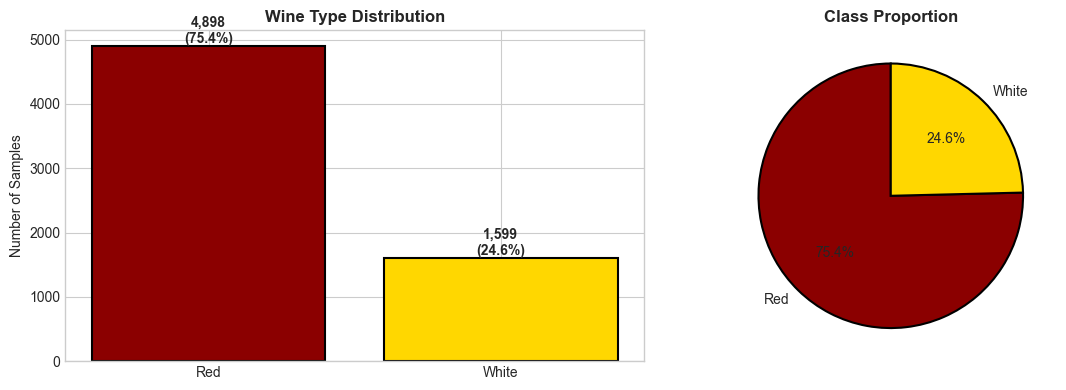


Class Imbalance Analysis:
• White wines dominate at 75.4%, red wines only 24.6%
• Imbalance ratio: 1:3.1 (red:white)
• Implications: Accuracy alone could be misleading; need balanced metrics (F1, precision/recall per class)


In [5]:
# Class distribution
class_counts = df['type'].value_counts()
class_pcts = df['type'].value_counts(normalize=True) * 100

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#8B0000', '#FFD700']
bars = ax1.bar(['Red', 'White'], class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Samples')
ax1.set_title('Wine Type Distribution', fontweight='bold')
for bar, count, pct in zip(bars, class_counts.values, class_pcts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}\n({pct:.1f}%)', ha='center', fontweight='bold')

# Pie chart
ax2.pie(class_counts.values, labels=['Red', 'White'], autopct='%1.1f%%', 
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Class Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretation
print(f"\nClass Imbalance Analysis:")
print(f"• White wines dominate at {class_pcts[1]:.1f}%, red wines only {class_pcts[0]:.1f}%")
print(f"• Imbalance ratio: 1:{class_counts[1]/class_counts[0]:.1f} (red:white)")
print(f"• Implications: Accuracy alone could be misleading; need balanced metrics (F1, precision/recall per class)")

## 4. Discriminative Feature Analysis

Examining the top 3 features that show clear separation between red and white wines.

In [6]:
# Calculate feature separation (difference in means normalized by pooled std)
feature_cols = df.columns[:-2]  # Exclude 'quality' and 'type'
separation_scores = {}

for col in feature_cols:
    red_mean = df[df['type'] == 0][col].mean()
    white_mean = df[df['type'] == 1][col].mean()
    pooled_std = np.sqrt((df[df['type'] == 0][col].std()**2 + df[df['type'] == 1][col].std()**2) / 2)
    separation_scores[col] = abs(red_mean - white_mean) / pooled_std

# Top 3 discriminative features
top_features = sorted(separation_scores.items(), key=lambda x: x[1], reverse=True)[:3]
print("Most Discriminative Features (by standardized mean difference):")
for feat, score in top_features:
    print(f"  {feat:25} {score:.2f}")

Most Discriminative Features (by standardized mean difference):
  total sulfur dioxide      2.42
  volatile acidity          1.72
  free sulfur dioxide       1.38


### Feature 1: Total Sulfur Dioxide

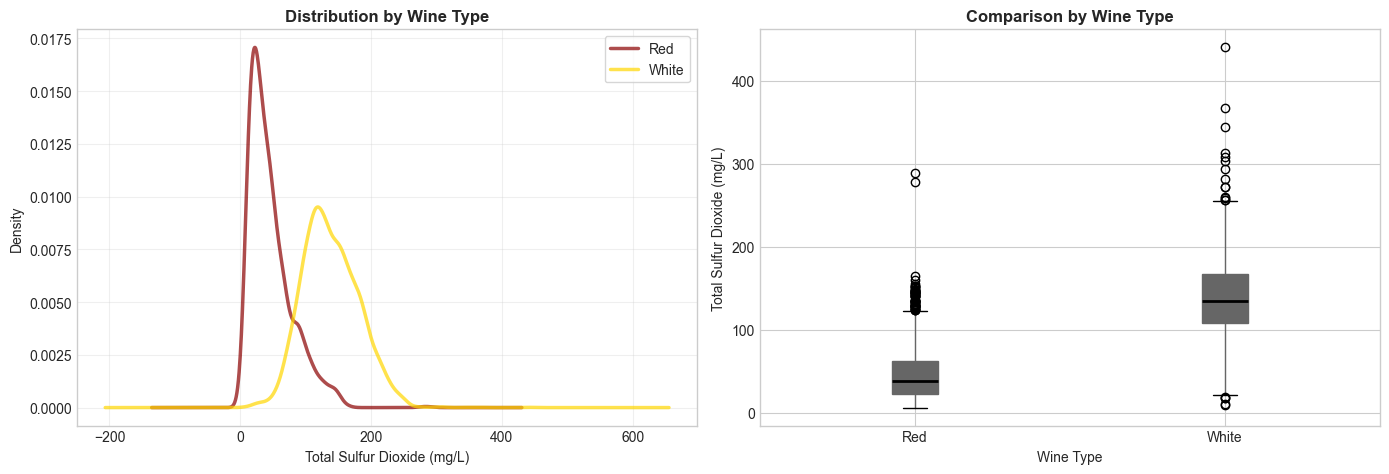

Total Sulfur Dioxide Insights:
• White wines: 138.4 ± 42.5 mg/L
• Red wines: 46.5 ± 32.9 mg/L
• Clear separation with minimal overlap — excellent discriminator
• White wines require more SO₂ for preservation (lighter color = less natural antioxidants)


In [7]:
# Total sulfur dioxide distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KDE plot
for wine_type, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['type'] == wine_type]['total sulfur dioxide']
    data.plot.kde(ax=ax1, color=color, linewidth=2.5, label=label, alpha=0.7)
ax1.set_xlabel('Total Sulfur Dioxide (mg/L)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution by Wine Type', fontweight='bold')
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3)

# Boxplot
df.boxplot(column='total sulfur dioxide', by='type', ax=ax2, 
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Total Sulfur Dioxide (mg/L)')
ax2.set_title('Comparison by Wine Type', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Interpretation
print("Total Sulfur Dioxide Insights:")
print(f"• White wines: {df[df['type']==1]['total sulfur dioxide'].mean():.1f} ± {df[df['type']==1]['total sulfur dioxide'].std():.1f} mg/L")
print(f"• Red wines: {df[df['type']==0]['total sulfur dioxide'].mean():.1f} ± {df[df['type']==0]['total sulfur dioxide'].std():.1f} mg/L")
print("• Clear separation with minimal overlap — excellent discriminator")
print("• White wines require more SO₂ for preservation (lighter color = less natural antioxidants)")

### Feature 2: Volatile Acidity

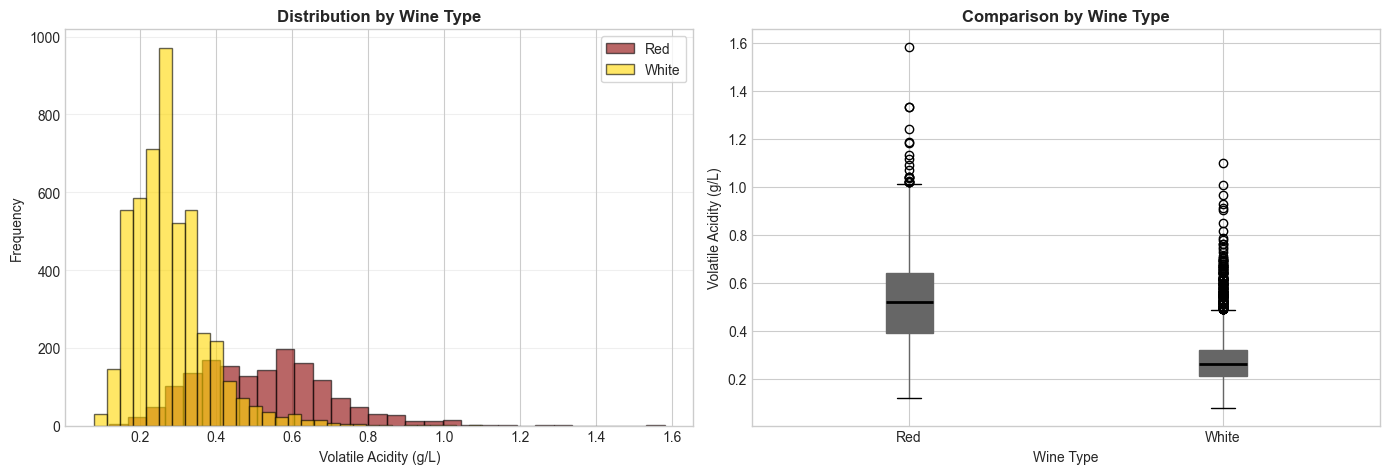

Volatile Acidity Insights:
• Red wines: 0.528 ± 0.179 g/L
• White wines: 0.278 ± 0.101 g/L
• Red wines show 2x higher volatile acidity (acetic acid from fermentation)
• Some overlap exists, but distributions are clearly shifted


In [8]:
# Volatile acidity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with overlap
for wine_type, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['type'] == wine_type]['volatile acidity']
    ax1.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
ax1.set_xlabel('Volatile Acidity (g/L)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution by Wine Type', fontweight='bold')
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3, axis='y')

# Boxplot
df.boxplot(column='volatile acidity', by='type', ax=ax2,
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Volatile Acidity (g/L)')
ax2.set_title('Comparison by Wine Type', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')

plt.tight_layout()
plt.show()

# Interpretation
print("Volatile Acidity Insights:")
print(f"• Red wines: {df[df['type']==0]['volatile acidity'].mean():.3f} ± {df[df['type']==0]['volatile acidity'].std():.3f} g/L")
print(f"• White wines: {df[df['type']==1]['volatile acidity'].mean():.3f} ± {df[df['type']==1]['volatile acidity'].std():.3f} g/L")
print("• Red wines show 2x higher volatile acidity (acetic acid from fermentation)")
print("• Some overlap exists, but distributions are clearly shifted")

### Feature 3: Chlorides

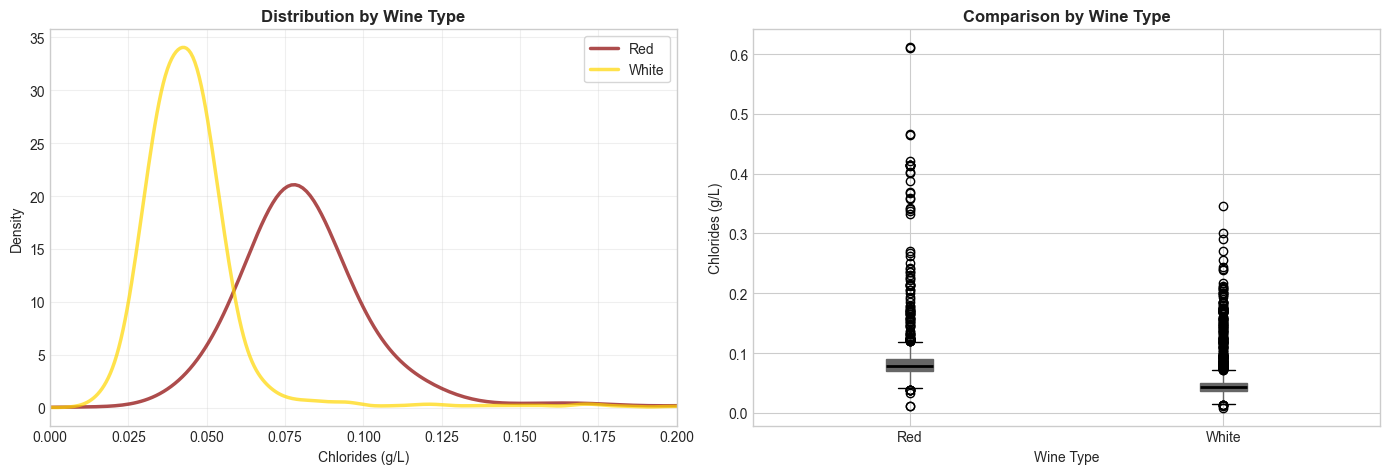

Chlorides (Salt Content) Insights:
• Red wines: 0.0875 ± 0.0471 g/L
• White wines: 0.0458 ± 0.0218 g/L
• Red wines have slightly higher salt content (terroir and processing differences)
• Many outliers in both classes — robust methods needed for modeling


In [9]:
# Chlorides distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KDE plot
for wine_type, color, label in [(0, '#8B0000', 'Red'), (1, '#FFD700', 'White')]:
    data = df[df['type'] == wine_type]['chlorides']
    data.plot.kde(ax=ax1, color=color, linewidth=2.5, label=label, alpha=0.7)
ax1.set_xlabel('Chlorides (g/L)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution by Wine Type', fontweight='bold')
ax1.legend(frameon=True, fancybox=True)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 0.2)  # Focus on main distribution

# Boxplot
df.boxplot(column='chlorides', by='type', ax=ax2,
           patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
ax2.set_xlabel('Wine Type')
ax2.set_ylabel('Chlorides (g/L)')
ax2.set_title('Comparison by Wine Type', fontweight='bold')
ax2.set_xticklabels(['Red', 'White'])
plt.suptitle('')

plt.tight_layout()
plt.show()

# Interpretation
print("Chlorides (Salt Content) Insights:")
print(f"• Red wines: {df[df['type']==0]['chlorides'].mean():.4f} ± {df[df['type']==0]['chlorides'].std():.4f} g/L")
print(f"• White wines: {df[df['type']==1]['chlorides'].mean():.4f} ± {df[df['type']==1]['chlorides'].std():.4f} g/L")
print("• Red wines have slightly higher salt content (terroir and processing differences)")
print("• Many outliers in both classes — robust methods needed for modeling")

## 5. Preprocessing Considerations

Notes for future modeling (notebook 03+):

In [10]:
# Check feature scales
print("Feature Scale Analysis:")
print("="*50)
scale_analysis = pd.DataFrame({
    'Feature': feature_cols,
    'Min': df[feature_cols].min(),
    'Max': df[feature_cols].max(),
    'Range': df[feature_cols].max() - df[feature_cols].min()
}).sort_values('Range', ascending=False)

print(scale_analysis.head().to_string(index=False))

print("\n📝 Preprocessing Notes:")
print("• Features have vastly different scales (e.g., SO₂ in 100s, chlorides in 0.0x)")
print("• StandardScaler needed for distance-based models (KNN, SVM, Logistic Regression)")
print("• Tree-based models (Random Forest, XGBoost) won't need scaling")
print("• CRITICAL: Fit scaler on training set only to prevent data leakage")
print("• Consider outlier handling for chlorides and residual sugar")

Feature Scale Analysis:
             Feature  Min   Max  Range
total sulfur dioxide  6.0 440.0  434.0
 free sulfur dioxide  1.0 289.0  288.0
      residual sugar  0.6  65.8   65.2
       fixed acidity  3.8  15.9   12.1
             alcohol  8.0  14.9    6.9

📝 Preprocessing Notes:
• Features have vastly different scales (e.g., SO₂ in 100s, chlorides in 0.0x)
• StandardScaler needed for distance-based models (KNN, SVM, Logistic Regression)
• Tree-based models (Random Forest, XGBoost) won't need scaling
• CRITICAL: Fit scaler on training set only to prevent data leakage
• Consider outlier handling for chlorides and residual sugar


## 6. Key Takeaways

1. **Strong class imbalance** (75% white, 25% red) — use stratified splits and balanced metrics
2. **Excellent separability** in total SO₂, volatile acidity, and chlorides
3. **No missing data** — rare luxury in real-world datasets
4. **Scale normalization required** for linear models
5. **Outliers present** but shouldn't break tree-based approaches

Ready for modeling in notebook 03!